# Equity Market Crisis Regime Prediction using Machine Learning GBDT

## Part II: Data Preparation

Quick access to the whole series:

1. [Part I: Introduction](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt1)
1. [Part II: Data Preparation](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt2)
1. [Part III: Exploratory data analysis](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt3)
1. [Part IV: Feature Selection, Hyperparameter Tuning (LightGBM)](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt4)
1. [Part V: Model Evaluation and Interpretation (LightGBM)](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt5)
1. [Part VI: SVM and Neural Networks (MLP and 1D-CNN)](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt6)
1. [Part VII: Compare GBDT Models: XGBoost and LightGBM](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt7)


## Load and install packages

In [1]:
import pandas as pd
import numpy as np
import os
import gc
import copy
from pathlib import Path
from datetime import datetime, timedelta, date
import time
from dateutil.relativedelta import relativedelta 

import pyarrow.parquet as pq
import pyarrow as pa

from tqdm import tqdm

In [2]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

pd.options.display.float_format = '{:,.2f}'.format

import warnings
warnings.filterwarnings("ignore")

import pytorch_lightning as pl
random_seed=1
pl.seed_everything(random_seed)

1

In [3]:
!pip install mplfinance==0.12.9b1
!pip install yfinance==0.1.66
!pip install fredapi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.9/70.9 kB 827.1 kB/s eta 0:00:00


## Download data

### Download data from yfinance

In [4]:
import yfinance as yf

In [5]:
#https://sg.finance.yahoo.com/world-indices/
#https://sg.finance.yahoo.com/bonds/
#https://sg.finance.yahoo.com/commodities/
benchmark_tickers = ['^GSPC', '^DJI', '^IXIC', '^RUT', '^VIX', 
                     '^TYX', '^TNX','^FVX', '^IRX','^NDX', 'DX-Y.NYB',  'EEM','IEMG','^FTSE','^STOXX50E',
                     '^N225', 'JPY=X', '^KS11', 'GC=F', 'CL=F', '^HSI', '^KLSE', '^N100'
                    ]#'^SPX'

In [6]:
#https://github.com/ranaroussi/yfinance/blob/main/yfinance/base.py
#     def history(self, period="1mo", interval="1d",
#                 start=None, end=None, prepost=False, actions=True,
#                 auto_adjust=True, back_adjust=False,
#                 proxy=None, rounding=False, tz=None, timeout=None, **kwargs):

dfs = {}

for ticker in  benchmark_tickers:
    cur_data = yf.Ticker(ticker)
    hist = cur_data.history(period="max")
    print(ticker, cur_data.info['shortName'], datetime.now(), ticker, hist.shape, hist.index.min(), hist.index.max())

    dfs[ticker] = hist
    


^GSPC S&P 500 2022-10-07 17:36:48.318597 ^GSPC (18311, 7) 1950-01-03 00:00:00 2022-10-07 00:00:00
^DJI Dow Jones Industrial Average 2022-10-07 17:36:54.165624 ^DJI (7751, 7) 1992-01-02 00:00:00 2022-10-07 00:00:00
^IXIC NASDAQ Composite 2022-10-07 17:37:00.555718 ^IXIC (13033, 7) 1971-02-05 00:00:00 2022-10-07 00:00:00
^RUT Russell 2000 2022-10-07 17:37:06.287041 ^RUT (8841, 7) 1987-09-10 00:00:00 2022-10-07 00:00:00
^VIX CBOE Volatility Index 2022-10-07 17:37:12.329849 ^VIX (8257, 7) 1990-01-02 00:00:00 2022-10-07 00:00:00
^TYX Treasury Yield 30 Years 2022-10-07 17:37:17.878894 ^TYX (11434, 7) 1977-02-15 00:00:00 2022-10-07 00:00:00
^TNX CBOE Interest Rate 10 Year T No 2022-10-07 17:37:24.243569 ^TNX (15204, 7) 1962-01-02 00:00:00 2022-10-07 00:00:00
^FVX Treasury Yield 5 Years 2022-10-07 17:37:29.990798 ^FVX (15204, 7) 1962-01-02 00:00:00 2022-10-07 00:00:00
^IRX 13 WEEK TREASURY BILL 2022-10-07 17:37:35.916970 ^IRX (15703, 7) 1960-01-04 00:00:00 2022-10-07 00:00:00
^NDX NASDAQ 100 2

In [7]:
df_target = dfs['^GSPC'].copy(deep=True)


In [8]:
#15day_pct change
df_target['pct_chg15'] = df_target['Close'].pct_change(15)
df_target['regime_change'] = df_target['pct_chg15'].rolling(window=5000, min_periods=2000).apply(lambda x:x[:-1].quantile(q=0.05)>x[-1])
#in the papers, the authors did not describe shifting the target. 
#here shift the target by n days to use X on d0 to predict if there will be a crisis regime in n days
df_target['target'] = df_target['regime_change'].shift(-3)

<AxesSubplot:xlabel='Date'>

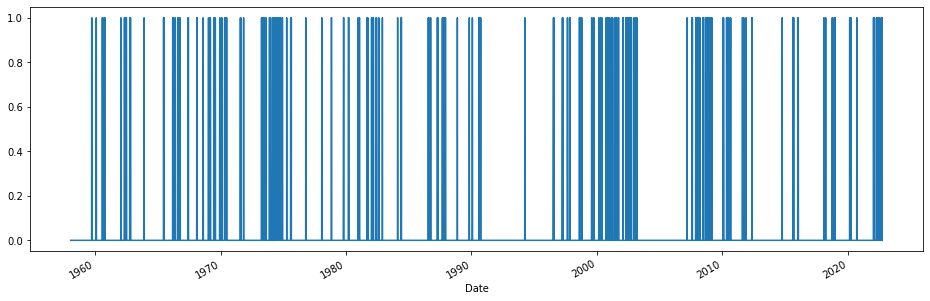

In [9]:
df_target['regime_change'].plot(figsize=(16, 5))

<AxesSubplot:xlabel='Date'>

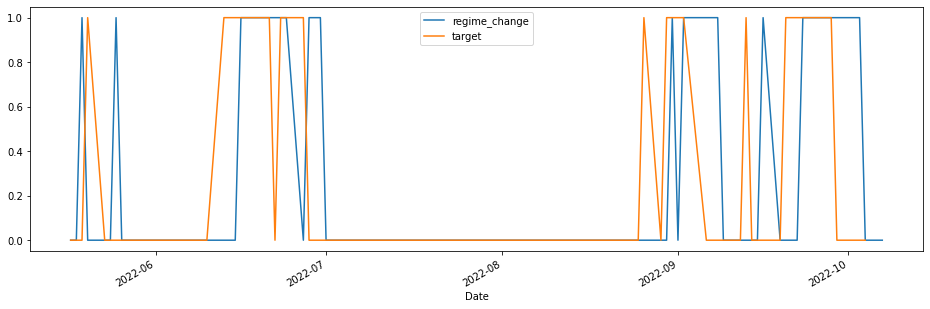

In [10]:
df_target[['regime_change', 'target']].tail(100).plot(figsize=(16, 5))

In [11]:
max_date = df_target.index.max()
max_date

Timestamp('2022-10-07 00:00:00')

### Download data from [fred.stlouisfed.org](https://fred.stlouisfed.org/)

In [12]:
# https://www.multpl.com/s-p-500-dividend-yield/table/by-month
# https://www.multpl.com/s-p-500-earnings
# https://www.multpl.com/s-p-500-pe-ratio/table/by-month
# https://www.multpl.com/shiller-pe/table/by-year
#https://fred.stlouisfed.org/categories/46

#https://fredaccount.stlouisfed.org/apikeys
#https://mortada.net/python-api-for-fred.html
#https://github.com/mortada/fredapi
#https://www.briancjenkins.com/fredpy/docs/build/html/fredpy_examples.html
from fredapi import Fred
fred = Fred('c8d4f8e608b42f6d85dd037f2080e451')

1. Volatility Indexes:  https://fred.stlouisfed.org/categories/32425 
1. Stock Market Indexes: https://fred.stlouisfed.org/categories/32255
1. Financial Activity Measures: https://fred.stlouisfed.org/categories/32457
1. BofA Merrill Lynch Total Bond Return Index Values: https://fred.stlouisfed.org/categories/32413
1. Total Nonfarm: https://fred.stlouisfed.org/categories/32305
1. Prices: https://fred.stlouisfed.org/categories/32455
1. Japan: https://fred.stlouisfed.org/categories/32281
1. Interest Rate Spreads: https://fred.stlouisfed.org/categories/33446
1. Foreign Exchange Intervention: https://fred.stlouisfed.org/categories/32145
1. Commercial Paper: https://fred.stlouisfed.org/categories/32996

In [13]:
sel_dfs = []

In [14]:
ids = [ 32425, 32255, 32457, 32413, 32305, 32455, 32281, 32241, 33446, 32145, 32996]
for id_ in ids:
    df = fred.search_by_category(id_, limit=25, order_by='popularity', sort_order='desc')
    sel_dfs.append(df[df['observation_start']<'2010-01-01'])
    display(df)

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
VIXCLS,VIXCLS,2022-10-07,2022-10-07,CBOE Volatility Index: VIX,1990-01-02,2022-10-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2022-10-07 08:36:04-05:00,77,VIX measures market expectation of near term v...
GVZCLS,GVZCLS,2022-10-07,2022-10-07,CBOE Gold ETF Volatility Index,2008-06-03,2022-10-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2022-10-07 08:36:03-05:00,56,Exchange Traded Funds (ETFs) are shares of tru...
VXVCLS,VXVCLS,2022-10-07,2022-10-07,CBOE S&P 500 3-Month Volatility Index,2007-12-04,2022-10-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2022-10-07 08:36:05-05:00,54,"Copyright, 2016, Chicago Board Options Exchang..."
OVXCLS,OVXCLS,2022-10-07,2022-10-07,CBOE Crude Oil ETF Volatility Index,2007-05-10,2022-10-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2022-10-07 08:36:03-05:00,46,Exchange Traded Funds (ETFs) are shares of tru...
VXNCLS,VXNCLS,2022-10-07,2022-10-07,CBOE NASDAQ 100 Volatility Index,2001-02-02,2022-10-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2022-10-07 08:36:05-05:00,42,"Copyright, 2016, Chicago Board Options Exchang..."
VXTYN,VXTYN,2022-10-07,2022-10-07,CBOE 10-Year Treasury Note Volatility Futures ...,2003-01-02,2020-05-15,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2020-06-17 09:20:48-05:00,40,"Copyright, 2016, Chicago Board Options Exchang..."
VXOCLS,VXOCLS,2022-10-07,2022-10-07,CBOE S&P 100 Volatility Index: VXO (DISCONTINUED),1986-01-02,2021-09-23,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2021-09-24 08:36:03-05:00,40,This series is no longer being updated by the ...
VXFXICLS,VXFXICLS,2022-10-07,2022-10-07,CBOE China ETF Volatility Index (DISCONTINUED),2011-03-16,2022-02-11,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2022-02-14 08:36:09-06:00,36,Exchange Traded Funds (ETFs) are shares of tru...
RVXCLS,RVXCLS,2022-10-07,2022-10-07,CBOE Russell 2000 Volatility Index,2004-01-02,2022-10-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2022-10-07 08:36:03-05:00,33,"Copyright, 2016, Chicago Board Options Exchang..."


,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
SP500,SP500,2022-10-07,2022-10-07,S&P 500,2012-10-08,2022-10-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2022-10-06 19:10:51-05:00,84,The observations for the S&P 500 represent the...
DJIA,DJIA,2022-10-07,2022-10-07,Dow Jones Industrial Average,2012-10-08,2022-10-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2022-10-06 19:01:02-05:00,74,The observations for the Dow Jones Industrial ...
NASDAQCOM,NASDAQCOM,2022-10-07,2022-10-07,NASDAQ Composite Index,1971-02-05,2022-10-06,"Daily, Close",D,"Index Feb 5, 1971=100","Index Feb 5, 1971=100",Not Seasonally Adjusted,NSA,2022-10-07 07:06:02-05:00,70,The observations for the NASDAQ Composite Inde...
WILL5000INDFC,WILL5000INDFC,2022-10-07,2022-10-07,Wilshire 5000 Total Market Full Cap Index,1970-12-31,2022-10-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2022-10-07 07:04:02-05:00,69,The observations for the Wilshire 5000 Total M...
WILL5000PRFC,WILL5000PRFC,2022-10-07,2022-10-07,Wilshire 5000 Full Cap Price Index,1970-12-31,2022-10-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2022-10-07 07:04:02-05:00,58,The observations for the Wilshire 5000 Full Ca...
NASDAQ100,NASDAQ100,2022-10-07,2022-10-07,NASDAQ 100 Index,1986-01-02,2022-10-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2022-10-07 07:06:02-05:00,54,The observations for the NASDAQ 100 Index repr...
WILL5000IND,WILL5000IND,2022-10-07,2022-10-07,Wilshire 5000 Total Market Index,1970-12-31,2022-10-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2022-10-07 07:04:02-05:00,50,The observations for the Wilshire 5000 Total M...
WILL5000PR,WILL5000PR,2022-10-07,2022-10-07,Wilshire 5000 Price Index,1970-12-31,2022-10-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2022-10-07 07:04:02-05:00,50,The observations for the Wilshire 5000 Price I...
WILLREITIND,WILLREITIND,2022-10-07,2022-10-07,Wilshire US Real Estate Investment Trust Total...,1977-12-30,2022-10-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2022-10-07 07:04:03-05:00,42,The observations for the Wilshire US Real Esta...


,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
UMCSENT,UMCSENT,2022-10-07,2022-10-07,University of Michigan: Consumer Sentiment,1952-11-01,2022-08-01,Monthly,M,Index 1966:Q1=100,Index 1966:Q1=100,Not Seasonally Adjusted,NSA,2022-09-30 10:01:01-05:00,82,"At the request of the source, the data is dela..."
NFCI,NFCI,2022-10-07,2022-10-07,Chicago Fed National Financial Conditions Index,1971-01-08,2022-09-30,"Weekly, Ending Friday",W,Index,Index,Not Seasonally Adjusted,NSA,2022-10-05 07:33:03-05:00,75,The Chicago Fed's National Financial Condition...
STLFSI3,STLFSI3,2022-10-07,2022-10-07,St. Louis Fed Financial Stress Index,1993-12-31,2022-09-30,"Weekly, Ending Friday",W,Index,Index,Not Seasonally Adjusted,NSA,2022-10-06 09:00:03-05:00,68,The STLFSI3 measures the degree of financial s...
STLFSI2,STLFSI2,2022-10-07,2022-10-07,St. Louis Fed Financial Stress Index (DISCONTI...,1993-12-31,2022-01-07,"Weekly, Ending Friday",W,Index,Index,Not Seasonally Adjusted,NSA,2022-01-13 07:10:51-06:00,68,The methodology for the St. Louis Fed's Financ...
USSLIND,USSLIND,2022-10-07,2022-10-07,Leading Index for the United States,1982-01-01,2020-02-01,Monthly,M,Percent,%,Seasonally Adjusted,SA,2020-04-14 09:16:10-05:00,68,The leading index for each state predicts the ...
ANFCI,ANFCI,2022-10-07,2022-10-07,Chicago Fed Adjusted National Financial Condit...,1971-01-08,2022-09-30,"Weekly, Ending Friday",W,Index,Index,Not Seasonally Adjusted,NSA,2022-10-05 07:33:12-05:00,59,The Chicago Fed’s National Financial Condition...
CFNAI,CFNAI,2022-10-07,2022-10-07,Chicago Fed National Activity Index,1967-03-01,2022-08-01,Monthly,M,Index,Index,Not Seasonally Adjusted,NSA,2022-09-26 07:34:02-05:00,56,A zero value for the index indicates that the ...
KCFSI,KCFSI,2022-10-07,2022-10-07,Kansas City Financial Stress Index,1990-02-01,2022-08-01,Monthly,M,Index,Index,Not Seasonally Adjusted,NSA,2022-09-09 14:16:02-05:00,55,"Starting with the September 14, 2021, release,..."
NFCICREDIT,NFCICREDIT,2022-10-07,2022-10-07,Chicago Fed National Financial Conditions Cred...,1971-01-08,2022-09-30,"Weekly, Ending Friday",W,Index,Index,Not Seasonally Adjusted,NSA,2022-10-05 07:33:21-05:00,53,The Chicago Fed’s National Financial Condition...


,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
BAMLHYH0A0HYM2TRIV,BAMLHYH0A0HYM2TRIV,2022-10-07,2022-10-07,ICE BofA US High Yield Index Total Return Inde...,1986-08-31,2022-10-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2022-10-07 09:16:11-05:00,66,This data represents the ICE BofA US High Yiel...
BAMLCC0A0CMTRIV,BAMLCC0A0CMTRIV,2022-10-07,2022-10-07,ICE BofA US Corporate Index Total Return Index...,1972-12-31,2022-10-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2022-10-07 09:26:02-05:00,53,This data represents the ICE BofA US Corporate...
BAMLHE00EHYITRIV,BAMLHE00EHYITRIV,2022-10-07,2022-10-07,ICE BofA Euro High Yield Index Total Return In...,1997-12-31,2022-10-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2022-10-07 09:15:10-05:00,42,This data represents the ICE BofA Euro High Yi...
BAMLHYH0A3CMTRIV,BAMLHYH0A3CMTRIV,2022-10-07,2022-10-07,ICE BofA CCC & Lower US High Yield Index Total...,1996-12-31,2022-10-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2022-10-07 09:15:12-05:00,38,This data represents the ICE BofA US Corporate...
BAMLEMCBPITRIV,BAMLEMCBPITRIV,2022-10-07,2022-10-07,ICE BofA Emerging Markets Corporate Plus Index...,1998-12-31,2022-10-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2022-10-07 09:21:03-05:00,37,The ICE BofA Emerging Markets Corporate Plus I...
BAMLCC4A0710YTRIV,BAMLCC4A0710YTRIV,2022-10-07,2022-10-07,ICE BofA 7-10 Year US Corporate Index Total Re...,1992-06-30,2022-10-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2022-10-07 09:24:08-05:00,35,This data represents the ICE BofA 7-10 Year US...
BAMLHYH0A1BBTRIV,BAMLHYH0A1BBTRIV,2022-10-07,2022-10-07,ICE BofA BB US High Yield Index Total Return I...,1996-12-31,2022-10-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2022-10-07 09:15:11-05:00,34,This data represents the ICE BofA US Corporate...
BAMLCC0A1AAATRIV,BAMLCC0A1AAATRIV,2022-10-07,2022-10-07,ICE BofA AAA US Corporate Index Total Return I...,1988-12-16,2022-10-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2022-10-07 09:25:05-05:00,33,This data represents the ICE BofA AAA US Corpo...
BAMLCC1A013YTRIV,BAMLCC1A013YTRIV,2022-10-07,2022-10-07,ICE BofA 1-3 Year US Corporate Index Total Ret...,1975-12-31,2022-10-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2022-10-07 09:25:06-05:00,32,This data represents the ICE BofA 1-3 Year US ...


,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
PAYEMS,PAYEMS,2022-10-07,2022-10-07,"All Employees, Total Nonfarm",1939-01-01,2022-09-01,Monthly,M,Thousands of Persons,Thous. of Persons,Seasonally Adjusted,SA,2022-10-07 07:45:01-05:00,83,"All Employees: Total Nonfarm, commonly known a..."
PAYNSA,PAYNSA,2022-10-07,2022-10-07,"All Employees, Total Nonfarm",1939-01-01,2022-09-01,Monthly,M,Thousands of Persons,Thous. of Persons,Not Seasonally Adjusted,NSA,2022-10-07 07:44:06-05:00,46,"All Employees: Total Nonfarm, commonly known a..."
CES0000000010,CES0000000010,2022-10-07,2022-10-07,"Women Employees, Total Nonfarm",1964-01-01,2022-09-01,Monthly,M,Thousands of Persons,Thous. of Persons,Seasonally Adjusted,SA,2022-10-07 07:45:03-05:00,11,The nonfarm business sector is a subset of the...
CES0000000039,CES0000000039,2022-10-07,2022-10-07,Women Employees-To-All Employees Ratio: Total ...,1964-01-01,2022-09-01,Monthly,M,Percent,%,Seasonally Adjusted,SA,2022-10-07 07:44:19-05:00,10,The nonfarm business sector is a subset of the...
CEU0000000010,CEU0000000010,2022-10-07,2022-10-07,"Women Employees, Total Nonfarm",1964-01-01,2022-09-01,Monthly,M,Thousands of Persons,Thous. of Persons,Not Seasonally Adjusted,NSA,2022-10-07 07:44:25-05:00,2,To obtain estimates of women worker employment...


,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
MICH,MICH,2022-10-07,2022-10-07,University of Michigan: Inflation Expectation,1978-01-01,2022-08-01,Monthly,M,Percent,%,Not Seasonally Adjusted,NSA,2022-09-30 10:01:01-05:00,77,"Median expected price change next 12 months, S..."
REAINTRATREARAT10Y,REAINTRATREARAT10Y,2022-10-07,2022-10-07,10-Year Real Interest Rate,1982-01-01,2022-09-01,Monthly,M,Percent,%,Not Seasonally Adjusted,NSA,2022-09-13 15:01:01-05:00,69,The Federal Reserve Bank of Cleveland estimate...
REAINTRATREARAT1YE,REAINTRATREARAT1YE,2022-10-07,2022-10-07,1-Year Real Interest Rate,1982-01-01,2022-09-01,Monthly,M,Percent,%,Not Seasonally Adjusted,NSA,2022-09-13 15:01:02-05:00,60,The Federal Reserve Bank of Cleveland estimate...
EXPINF1YR,EXPINF1YR,2022-10-07,2022-10-07,1-Year Expected Inflation,1982-01-01,2022-09-01,Monthly,M,Percent,%,Not Seasonally Adjusted,NSA,2022-09-13 15:01:02-05:00,60,The Federal Reserve Bank of Cleveland estimate...
EXPINF2YR,EXPINF2YR,2022-10-07,2022-10-07,2-Year Expected Inflation,1982-01-01,2022-09-01,Monthly,M,Percent,%,Not Seasonally Adjusted,NSA,2022-09-13 15:01:03-05:00,58,The Federal Reserve Bank of Cleveland estimate...
EXPINF10YR,EXPINF10YR,2022-10-07,2022-10-07,10-Year Expected Inflation,1982-01-01,2022-09-01,Monthly,M,Percent,%,Not Seasonally Adjusted,NSA,2022-09-13 15:01:02-05:00,55,The Federal Reserve Bank of Cleveland estimate...
EXPINF5YR,EXPINF5YR,2022-10-07,2022-10-07,5-Year Expected Inflation,1982-01-01,2022-09-01,Monthly,M,Percent,%,Not Seasonally Adjusted,NSA,2022-09-13 15:01:03-05:00,45,The Federal Reserve Bank of Cleveland estimate...
STLPPM,STLPPM,2022-10-07,2022-10-07,Price Pressures Measure,1990-01-01,2022-09-01,Monthly,M,Probability,Probability,Not Seasonally Adjusted,NSA,2022-09-30 20:20:02-05:00,43,This series measures the probability that the ...
EXPINF30YR,EXPINF30YR,2022-10-07,2022-10-07,30-Year Expected Inflation,1982-01-01,2022-09-01,Monthly,M,Percent,%,Not Seasonally Adjusted,NSA,2022-09-13 15:01:03-05:00,40,The Federal Reserve Bank of Cleveland estimate...


,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
QJPN628BIS,QJPN628BIS,2022-10-07,2022-10-07,Residential Property Prices for Japan,1955-01-01,2022-01-01,Quarterly,Q,Index 2010=100,Index 2010=100,Not Seasonally Adjusted,NSA,2022-09-29 11:02:02-05:00,67,Source Code: Q:JP:N:628 Coverage includes lan...
JPNRGDPEXP,JPNRGDPEXP,2022-10-07,2022-10-07,Real Gross Domestic Product for Japan,1994-01-01,2022-04-01,Quarterly,Q,Billions of Chained 2015 Yen,Bil. of Chn. 2015 Yen,Seasonally Adjusted,SA,2022-09-07 18:56:02-05:00,63,"Copyright, 2016, Cabinet Office of Japan."
JPNCPIALLMINMEI,JPNCPIALLMINMEI,2022-10-07,2022-10-07,Consumer Price Index of All Items in Japan,1960-01-01,2022-04-01,Monthly,M,Index 2015=100,Index 2015=100,Not Seasonally Adjusted,NSA,2022-06-14 10:46:03-05:00,59,"Copyright, 2016, OECD. Reprinted with permissi..."
JPNASSETS,JPNASSETS,2022-10-07,2022-10-07,Bank of Japan: Total Assets for Japan,1998-04-01,2022-08-01,"Monthly, End of Period",M,100 Million Yen,100 Mil. Yen,Not Seasonally Adjusted,NSA,2022-09-04 20:11:01-05:00,57,"Copyright, 2016, Bank of Japan."
NIKKEI225,NIKKEI225,2022-10-07,2022-10-07,"Nikkei Stock Average, Nikkei 225",1949-05-16,2022-10-07,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2022-10-07 07:02:06-05:00,55,"The observations for the Nikkei Stock Average,..."
JPNNGDP,JPNNGDP,2022-10-07,2022-10-07,Gross Domestic Product for Japan,1994-01-01,2022-04-01,Quarterly,Q,Billions of Yen,Bil. of Yen,Seasonally Adjusted,SA,2022-09-07 18:56:02-05:00,55,"Copyright, 2016, Cabinet Office of Japan."
IRLTLT01JPM156N,IRLTLT01JPM156N,2022-10-07,2022-10-07,Long-Term Government Bond Yields: 10-year: Mai...,1989-01-01,2022-08-01,Monthly,M,Percent,%,Not Seasonally Adjusted,NSA,2022-09-14 14:51:03-05:00,53,OECD descriptor ID: IRLTLT01 OECD unit ID: ST ...
INTDSRJPM193N,INTDSRJPM193N,2022-10-07,2022-10-07,"Interest Rates, Discount Rate for Japan",1953-01-01,2017-04-01,Monthly,M,Percent per Annum,% per Annum,Not Seasonally Adjusted,NSA,2019-04-29 07:02:01-05:00,50,Notes regarding this series can be found in In...
MYAGM2JPM189S,MYAGM2JPM189S,2022-10-07,2022-10-07,M2 for Japan,1955-01-01,2017-02-01,Monthly,M,National Currency,National Currency,Seasonally Adjusted,SA,2017-07-03 11:31:03-05:00,50,M2 comprises notes and coins in circulation ou...


,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
JTSOSL,JTSOSL,2022-10-07,2022-10-07,Other Separations: Total Nonfarm,2000-12-01,2022-08-01,Monthly,M,Level in Thousands,Level in Thous.,Seasonally Adjusted,SA,2022-10-04 09:06:03-05:00,29,None
JTS1000OSL,JTS1000OSL,2022-10-07,2022-10-07,Other Separations: Total Private,2000-12-01,2022-08-01,Monthly,M,Level in Thousands,Level in Thous.,Seasonally Adjusted,SA,2022-10-04 09:06:05-05:00,15,None
JTSOSR,JTSOSR,2022-10-07,2022-10-07,Other Separations: Total Nonfarm,2000-12-01,2022-08-01,Monthly,M,Rate,Rate,Seasonally Adjusted,SA,2022-10-04 09:06:08-05:00,15,None
JTS9000OSR,JTS9000OSR,2022-10-07,2022-10-07,Other Separations: Government,2000-12-01,2022-08-01,Monthly,M,Rate,Rate,Seasonally Adjusted,SA,2022-10-04 09:06:08-05:00,8,None
JTS1000OSR,JTS1000OSR,2022-10-07,2022-10-07,Other Separations: Total Private,2000-12-01,2022-08-01,Monthly,M,Rate,Rate,Seasonally Adjusted,SA,2022-10-04 09:06:09-05:00,3,None
JTS9000OSL,JTS9000OSL,2022-10-07,2022-10-07,Other Separations: Government,2000-12-01,2022-08-01,Monthly,M,Level in Thousands,Level in Thous.,Seasonally Adjusted,SA,2022-10-04 09:06:21-05:00,2,None


,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
T10Y2Y,T10Y2Y,2022-10-07,2022-10-07,10-Year Treasury Constant Maturity Minus 2-Yea...,1976-06-01,2022-10-06,Daily,D,Percent,%,Not Seasonally Adjusted,NSA,2022-10-06 16:01:03-05:00,100,"Starting with the update on June 21, 2019, the..."
T10YIE,T10YIE,2022-10-07,2022-10-07,10-Year Breakeven Inflation Rate,2003-01-02,2022-10-06,Daily,D,Percent,%,Not Seasonally Adjusted,NSA,2022-10-06 16:01:04-05:00,94,The breakeven inflation rate represents a meas...
T10Y3M,T10Y3M,2022-10-07,2022-10-07,10-Year Treasury Constant Maturity Minus 3-Mon...,1982-01-04,2022-10-06,Daily,D,Percent,%,Not Seasonally Adjusted,NSA,2022-10-06 16:01:03-05:00,93,Series is calculated as the spread between 10-...
T5YIE,T5YIE,2022-10-07,2022-10-07,5-Year Breakeven Inflation Rate,2003-01-02,2022-10-06,Daily,D,Percent,%,Not Seasonally Adjusted,NSA,2022-10-06 16:01:04-05:00,90,The breakeven inflation rate represents a meas...
T5YIFR,T5YIFR,2022-10-07,2022-10-07,"5-Year, 5-Year Forward Inflation Expectation Rate",2003-01-02,2022-10-06,Daily,D,Percent,%,Not Seasonally Adjusted,NSA,2022-10-06 16:01:04-05:00,88,This series is a measure of expected inflation...
BAA10Y,BAA10Y,2022-10-07,2022-10-07,Moody's Seasoned Baa Corporate Bond Yield Rela...,1986-01-02,2022-10-04,Daily,D,Percent,%,Not Seasonally Adjusted,NSA,2022-10-05 16:01:02-05:00,78,Series is calculated as the spread between Moo...
TEDRATE,TEDRATE,2022-10-07,2022-10-07,TED Spread (DISCONTINUED),1986-01-02,2022-01-21,Daily,D,Percent,%,Not Seasonally Adjusted,NSA,2022-01-28 16:01:02-06:00,75,Series is calculated as the spread between 3-M...
T10YFF,T10YFF,2022-10-07,2022-10-07,10-Year Treasury Constant Maturity Minus Feder...,1962-01-02,2022-10-05,Daily,D,Percent,%,Not Seasonally Adjusted,NSA,2022-10-06 16:01:03-05:00,74,Series is calculated as the spread between 10-...
AAA10Y,AAA10Y,2022-10-07,2022-10-07,Moody's Seasoned Aaa Corporate Bond Yield Rela...,1983-01-03,2022-10-04,Daily,D,Percent,%,Not Seasonally Adjusted,NSA,2022-10-05 16:02:01-05:00,69,Series is calculated as the spread between Moo...


,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
JPINTDUSDJPY,JPINTDUSDJPY,2022-10-07,2022-10-07,Japan Intervention: Japanese Bank purchases of...,1991-04-01,2022-06-30,"Daily, 7-Day",D,100 Million Yen,100 Mil. Yen,Not Seasonally Adjusted,NSA,2022-08-05 16:34:01-05:00,38,(+) numbers mean purchases of the USD (sell Ye...
USINTDMRKTJPY,USINTDMRKTJPY,2022-10-07,2022-10-07,U.S. Intervention: in Market Transactions in t...,1973-03-02,2011-05-31,"Daily, 7-Day",D,Millions of USD,Mil. of USD,Not Seasonally Adjusted,NSA,2019-09-19 14:42:03-05:00,24,"(+) numbers mean purchases of USD, (-) numbers..."
TRINTDEXR,TRINTDEXR,2022-10-07,2022-10-07,Turkish Intervention: Central Bank of Turkey P...,2002-01-01,2022-10-03,"Daily, 7-Day",D,Millions of USD,Mil. of USD,Not Seasonally Adjusted,NSA,2022-10-03 09:01:13-05:00,19,"(+) numbers mean purchases of USD, (-) numbers..."
USINTDMRKTOTH,USINTDMRKTOTH,2022-10-07,2022-10-07,U.S. Intervention: in Market Transactions in O...,1973-03-02,2011-05-31,"Daily, 7-Day",D,Millions of USD,Mil. of USD,Not Seasonally Adjusted,NSA,2019-09-19 14:42:25-05:00,17,"(+) numbers mean purchases of USD, (-) numbers..."
CHINTDCHFUSD,CHINTDCHFUSD,2022-10-07,2022-10-07,Swiss Intervention: Swiss National Bank Purcha...,1986-01-01,2001-04-05,"Daily, 7-Day",D,Millions of USD,Mil. of USD,Not Seasonally Adjusted,NSA,2009-06-30 10:16:38-05:00,14,"Copyright, 2016, Swiss National Bank. (+) num..."
MEXINTDUSD,MEXINTDUSD,2022-10-07,2022-10-07,Mexican Intervention: Banco de Mexico Purchase...,1997-10-27,2011-05-31,Daily,D,Millions of USD,Mil. of USD,Not Seasonally Adjusted,NSA,2011-07-01 11:01:25-05:00,9,Source: Banco de Mexico: http://www.banxico.or...
USINTDMRKTDM,USINTDMRKTDM,2022-10-07,2022-10-07,U.S. Intervention: in Market Transactions in t...,1973-03-02,2011-05-31,"Daily, 7-Day",D,Millions of USD,Mil. of USD,Not Seasonally Adjusted,NSA,2019-09-19 14:42:46-05:00,9,"(+)numbers mean purchases of USD, (-) numbers ..."
AUINTDDL,AUINTDDL,2022-10-07,2022-10-07,Australian Bank Transactions: RBA Spot and For...,1983-12-12,2006-12-29,"Daily, 7-Day",D,Millions of AUD,Mil. of AUD,Not Seasonally Adjusted,NSA,2008-03-03 13:46:26-06:00,7,"Copyright, 2016, Reserve Bank of Australia. (..."
DEINTDUSDDM,DEINTDUSDDM,2022-10-07,2022-10-07,German Intervention: Bundesbank Purchases on t...,1976-01-02,1995-12-29,"Daily, 7-Day",D,Millions of DEM,Mil. of DEM,Not Seasonally Adjusted,NSA,2008-03-03 14:32:10-06:00,5,Source: European Central Bank (ECB). (+) numb...


,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
COMPOUT,COMPOUT,2022-10-07,2022-10-07,Commercial Paper Outstanding,2001-01-03,2022-10-05,"Weekly, Ending Wednesday",W,Billions of Dollars,Bil. of $,Seasonally Adjusted,SA,2022-10-06 12:14:02-05:00,43,"For more information, please refer to http://w..."
ABCOMP,ABCOMP,2022-10-07,2022-10-07,Asset-Backed Commercial Paper Outstanding,2001-01-03,2022-10-05,"Weekly, Ending Wednesday",W,Billions of Dollars,Bil. of $,Seasonally Adjusted,SA,2022-10-06 12:14:01-05:00,38,"For more information, please refer to http://w..."
COMPAPER,COMPAPER,2022-10-07,2022-10-07,Nonfinancial Commercial Paper Outstanding,2001-01-03,2022-10-05,"Weekly, Ending Wednesday",W,Billions of Dollars,Bil. of $,Not Seasonally Adjusted,NSA,2022-10-06 12:14:02-05:00,15,Current data appear at http://www.federalreser...
NFINCP,NFINCP,2022-10-07,2022-10-07,Nonfinancial Commercial Paper Outstanding,2001-01-03,2022-10-05,"Weekly, Ending Wednesday",W,Billions of Dollars,Bil. of $,Seasonally Adjusted,SA,2022-10-06 12:14:05-05:00,11,"For more information, please refer to http://w..."
COMPUTN,COMPUTN,2022-10-07,2022-10-07,Commercial Paper Outstanding,2001-01-03,2022-10-05,"Weekly, Ending Wednesday",W,Billions of Dollars,Bil. of $,Not Seasonally Adjusted,NSA,2022-10-06 12:14:02-05:00,10,"For more information, please refer to http://w..."
FINCPN,FINCPN,2022-10-07,2022-10-07,Financial Commercial Paper Outstanding,2001-01-03,2022-10-05,"Weekly, Ending Wednesday",W,Billions of Dollars,Bil. of $,Not Seasonally Adjusted,NSA,2022-10-06 12:14:05-05:00,8,"For more information, please refer to http://w..."
DTBSPCKCT2NM,DTBSPCKCT2NM,2022-10-07,2022-10-07,"Commercial Paper Outstanding, Tier-2",2001-01-01,2022-09-01,Monthly,M,Millions of Dollars,Mil. of $,Not Seasonally Adjusted,NSA,2022-10-03 12:11:02-05:00,7,"For more information, please see http://www.fe..."
ABCOMPN,ABCOMPN,2022-10-07,2022-10-07,Asset-Backed Commercial Paper Outstanding,2001-01-03,2022-10-05,"Weekly, Ending Wednesday",W,Billions of Dollars,Bil. of $,Not Seasonally Adjusted,NSA,2022-10-06 12:13:02-05:00,7,"For more information, please refer to http://w..."
FINCP,FINCP,2022-10-07,2022-10-07,Financial Commercial Paper Outstanding,2001-01-03,2022-10-05,"Weekly, Ending Wednesday",W,Billions of Dollars,Bil. of $,Seasonally Adjusted,SA,2022-10-06 12:14:05-05:00,7,"For more information, please refer to http://w..."


In [15]:
df_desc = pd.concat(sel_dfs)
df_desc['popularity'] = df_desc['popularity'].astype(int)
df_desc['discontinued'] = df_desc['title'].apply(lambda x: 'DISCONTINUED' in x)
df_desc.sort_values(by='popularity', ascending=False, inplace=True)

In [16]:
df_desc.sort_values(by='popularity', ascending=False, inplace=True)

In [17]:
filter_by = (~df_desc['discontinued'] & (~df_desc['frequency_short'].isin(['Q', 'A'])))

In [18]:
df_desc[filter_by].head(100)

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes,discontinued
series id,,,,,,,,,,,,,,,,
T10Y2Y,T10Y2Y,2022-10-07,2022-10-07,10-Year Treasury Constant Maturity Minus 2-Yea...,1976-06-01,2022-10-06,Daily,D,Percent,%,Not Seasonally Adjusted,NSA,2022-10-06 16:01:03-05:00,100,"Starting with the update on June 21, 2019, the...",False
T10YIE,T10YIE,2022-10-07,2022-10-07,10-Year Breakeven Inflation Rate,2003-01-02,2022-10-06,Daily,D,Percent,%,Not Seasonally Adjusted,NSA,2022-10-06 16:01:04-05:00,94,The breakeven inflation rate represents a meas...,False
T10Y3M,T10Y3M,2022-10-07,2022-10-07,10-Year Treasury Constant Maturity Minus 3-Mon...,1982-01-04,2022-10-06,Daily,D,Percent,%,Not Seasonally Adjusted,NSA,2022-10-06 16:01:03-05:00,93,Series is calculated as the spread between 10-...,False
T5YIE,T5YIE,2022-10-07,2022-10-07,5-Year Breakeven Inflation Rate,2003-01-02,2022-10-06,Daily,D,Percent,%,Not Seasonally Adjusted,NSA,2022-10-06 16:01:04-05:00,90,The breakeven inflation rate represents a meas...,False
T5YIFR,T5YIFR,2022-10-07,2022-10-07,"5-Year, 5-Year Forward Inflation Expectation Rate",2003-01-02,2022-10-06,Daily,D,Percent,%,Not Seasonally Adjusted,NSA,2022-10-06 16:01:04-05:00,88,This series is a measure of expected inflation...,False
PAYEMS,PAYEMS,2022-10-07,2022-10-07,"All Employees, Total Nonfarm",1939-01-01,2022-09-01,Monthly,M,Thousands of Persons,Thous. of Persons,Seasonally Adjusted,SA,2022-10-07 07:45:01-05:00,83,"All Employees: Total Nonfarm, commonly known a...",False
UMCSENT,UMCSENT,2022-10-07,2022-10-07,University of Michigan: Consumer Sentiment,1952-11-01,2022-08-01,Monthly,M,Index 1966:Q1=100,Index 1966:Q1=100,Not Seasonally Adjusted,NSA,2022-09-30 10:01:01-05:00,82,"At the request of the source, the data is dela...",False
BAA10Y,BAA10Y,2022-10-07,2022-10-07,Moody's Seasoned Baa Corporate Bond Yield Rela...,1986-01-02,2022-10-04,Daily,D,Percent,%,Not Seasonally Adjusted,NSA,2022-10-05 16:01:02-05:00,78,Series is calculated as the spread between Moo...,False
VIXCLS,VIXCLS,2022-10-07,2022-10-07,CBOE Volatility Index: VIX,1990-01-02,2022-10-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2022-10-07 08:36:04-05:00,77,VIX measures market expectation of near term v...,False


In [19]:
df_desc[filter_by]['frequency'].value_counts()

Monthly                     73
Daily, Close                47
Daily                       25
Daily, 7-Day                17
Weekly, Ending Wednesday    12
Weekly, Ending Friday        7
Monthly, End of Period       1
Name: frequency, dtype: int64

In [20]:
df_desc[filter_by]['frequency_short'].value_counts()

D    89
M    74
W    19
Name: frequency_short, dtype: int64

In [21]:
start_date = '2000-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')
end_date

'2022-10-07'

#### Download data using api

- Data series skipped:  Quarterly and Annual data
- Data series downloaded: top 100 by popularity, and Daily, Weekly, and Monthly data.


In [22]:
%%time
fed_data_dict = {}
for series_id, row in df_desc[filter_by].head(100).iterrows():
    data = fred.get_series(series_id, observation_start=start_date, observation_end=end_date)
    fed_data_dict[series_id] = data
    

CPU times: user 32.1 s, sys: 202 ms, total: 32.3 s
Wall time: 1min 44s


#### Process data

For `Today`:  Grab data - most recent data will be yesterday's data updated at day-end - to predict if crisis regime is going to happen in ? days

- For `daily` frequency data: check the difference (in days) between last_updated and max_date (from target data), and make the x_date shift by n
    - if n<1, day-end update. x_date is the date 
    - if n>=1: shift 
- For `weekly` and `monthly` data:
    - convert to daily
    - shift the date to update date

In [23]:
fed_dfs = {}
for series_id, data in fed_data_dict.items():
    row = df_desc.loc[series_id]
    #n_diff = (datetime.now(tz=row['last_updated'].tzinfo) - row['last_updated']).days
    #n_diff = (max_date - datetime.strptime(row['last_updated'].strftime('%Y-%m-%d'),'%Y-%m-%d')).days
    
    #process daily data
    if row['frequency_short']=='D': 
        n_diff = (max_date - datetime.strptime(data.index.max().strftime('%Y-%m-%d'),'%Y-%m-%d')).days
        data.index.name='date'
        data.name=series_id
        data = data.to_frame().reset_index()
        print(row['frequency_short'],series_id, row['last_updated'], n_diff)
        
        if n_diff<1:
            data['x_date'] = data['date']
        else:
            #data['x_date'] = data['date'].shift(-n_diff)
            data['x_date'] = data['date'].shift(-n_diff).tolist()[:-n_diff] + df_target.index[-n_diff:].tolist()
        fed_dfs[series_id] = data
    else: #monthly/weekly data
        data.index.name='date'
        data.name=series_id
        data = data.to_frame().reset_index()
        
        n_diff = (datetime.strptime(row['last_updated'].strftime('%Y-%m-%d'),'%Y-%m-%d') - data['date'].max()).days 
        data['x_date'] = data['date'].apply(lambda x: x+relativedelta(days=n_diff))
        
        data_ = pd.DataFrame({'x_date':pd.date_range(start=data['x_date'].min(), end=data['x_date'].max(), freq='D')})
        data_ = data_.merge(data,  on='x_date', how='left')
        data_.fillna(method='ffill', inplace=True)
        
        print(row['frequency_short'],series_id, row['last_updated'], n_diff)
        fed_dfs[series_id] = data_

D T10Y2Y 2022-10-06 16:01:03-05:00 1
D T10YIE 2022-10-06 16:01:04-05:00 1
D T10Y3M 2022-10-06 16:01:03-05:00 1
D T5YIE 2022-10-06 16:01:04-05:00 1
D T5YIFR 2022-10-06 16:01:04-05:00 1
M PAYEMS 2022-10-07 07:45:01-05:00 36
M UMCSENT 2022-09-30 10:01:01-05:00 60
D BAA10Y 2022-10-05 16:01:02-05:00 3
D VIXCLS 2022-10-07 08:36:04-05:00 1
M MICH 2022-09-30 10:01:01-05:00 60
W NFCI 2022-10-05 07:33:03-05:00 5
D T10YFF 2022-10-06 16:01:03-05:00 2
D NASDAQCOM 2022-10-07 07:06:02-05:00 1
D AAA10Y 2022-10-05 16:02:01-05:00 3
M REAINTRATREARAT10Y 2022-09-13 15:01:01-05:00 12
D WILL5000INDFC 2022-10-07 07:04:02-05:00 1
M USSLIND 2020-04-14 09:16:10-05:00 73
W STLFSI3 2022-10-06 09:00:03-05:00 6
D BAMLHYH0A0HYM2TRIV 2022-10-07 09:16:11-05:00 1
M REAINTRATREARAT1YE 2022-09-13 15:01:02-05:00 12
M EXPINF1YR 2022-09-13 15:01:02-05:00 12
M JPNCPIALLMINMEI 2022-06-14 10:46:03-05:00 74
W ANFCI 2022-10-05 07:33:12-05:00 5
D WILL5000PRFC 2022-10-07 07:04:02-05:00 1
M EXPINF2YR 2022-09-13 15:01:03-05:00 12
D 

### Combine data

In [24]:
df = df_target[['pct_chg15', 'regime_change', 'target']].copy(deep=True)#'^GSPC'

In [25]:
for ticker, data in dfs.items():
    df = df.merge(data[['Close']], left_index=True, right_index=True, how='left')
    df.rename(columns={'Close': ticker.replace('^', '')}, inplace=True)
df.index.name='x_date'
df.reset_index(drop=False, inplace=True)

In [26]:
for c,data in fed_dfs.items():
    print(c, data.shape)
    df = df.merge(data[['x_date', c]], on='x_date', how='left')
    

T10Y2Y (5939, 3)
T10YIE (5156, 3)
T10Y3M (5939, 3)
T5YIE (5156, 3)
T5YIFR (5156, 3)
PAYEMS (8280, 3)
UMCSENT (8249, 3)
BAA10Y (5937, 3)
VIXCLS (5939, 3)
MICH (8249, 3)
NFCI (8303, 3)
T10YFF (5938, 3)
NASDAQCOM (5939, 3)
AAA10Y (5937, 3)
REAINTRATREARAT10Y (8280, 3)
WILL5000INDFC (5939, 3)
USSLIND (7337, 3)
STLFSI3 (8303, 3)
BAMLHYH0A0HYM2TRIV (6015, 3)
REAINTRATREARAT1YE (8280, 3)
EXPINF1YR (8280, 3)
JPNCPIALLMINMEI (8127, 3)
ANFCI (8303, 3)
WILL5000PRFC (5939, 3)
EXPINF2YR (8280, 3)
CPFF (5938, 3)
JPNASSETS (8249, 3)
T10Y2YM (8280, 3)
CFNAI (8249, 3)
GVZCLS (3743, 3)
T20YIEM (6637, 3)
EXPINF10YR (8280, 3)
KCFSI (8249, 3)
NIKKEI225 (5940, 3)
VXVCLS (3873, 3)
NASDAQ100 (5939, 3)
T10YIEM (7184, 3)
NFCICREDIT (8303, 3)
IRLTLT01JPM156N (8249, 3)
BAMLCC0A0CMTRIV (6015, 3)
TB3SMFFM (8280, 3)
MYAGM2JPM189S (6242, 3)
T5YFF (5938, 3)
INTDSRJPM193N (6301, 3)
NFCILEVERAGE (8303, 3)
WILL5000IND (5939, 3)
WILL5000PR (5939, 3)
T1YFF (5938, 3)
LFWA64TTJPM647S (8218, 3)
NFCIRISK (8303, 3)
OVXCLS (4021

In [27]:
df = df[df['x_date']>='2000-01-01'].copy(deep=True)

In [28]:
df.isna().sum().sort_values().tail(100)

TB3SMFFM                25
T10Y3MM                 25
BAA10YM                 25
T10Y2YM                 25
BAAFFM                  25
TENEXPCHAREARISPRE      26
REAINTRATREARAT1YE      26
EXPINF10YR              26
EXPINF1YR               26
REAINTRATREARAT10Y      26
REAINTRATREARAT1MO      26
TENEXPCHAINFRISPRE      26
EXPINF5YR               26
EXPINF2YR               26
EXPINF3YR               26
EXPINF30YR              26
JPY=X                   30
UMCSENT                 45
RBJPBIS                 45
MICH                    45
IRLTLT01JPM156N         46
IRSTCI01JPM156N         46
KCFSI                   46
IRSTCB01JPM156N         46
CFNAIDIFF               47
CFNAIMA3                47
JPNASSETS               47
CFNAI                   47
N100                    57
BAMLHYH0A3CMTRIV        64
BAMLCC0A0CMTRIV         64
BAMLEMCBPITRIV          64
BAMLCC4A0710YTRIV       64
BAMLHE00EHYITRIV        64
BAMLCC0A1AAATRIV        64
BAMLCC0A4BBBTRIV        64
BAMLHYH0A0HYM2TRIV      64
B

In [29]:
df.reset_index(drop=True, inplace=True)

<AxesSubplot:>

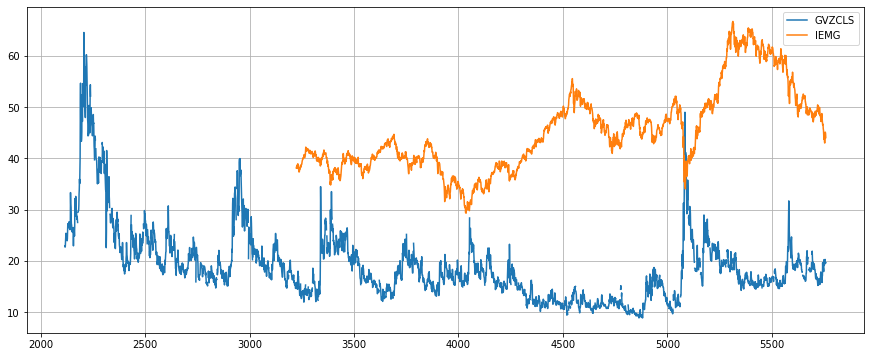

In [30]:
df[['GVZCLS','IEMG']].plot(figsize=(15, 6), grid=True)

In [31]:
print(df.shape)
df.dropna(how='any', subset=['target'], inplace=True)
print(df.shape)

(5759, 127)
(5756, 127)


In [32]:
df.replace([-np.inf, np.inf], np.nan, inplace=True)
df.isna().sum()[df.isna().sum()>0]

TYX                   7
TNX                   7
FVX                   7
IRX                   7
DX-Y.NYB              2
                   ... 
WILLSMLCAP          208
JTSOSL              275
MABMM301JPM189S      65
EVZCLS             2113
IRSTCB01JPM156N      43
Length: 117, dtype: int64

In [33]:
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

In [34]:
df.isna().sum()[df.isna().sum()>0]

Series([], dtype: int64)

## Feature engineering

In [35]:
#calculate volatility
def cal_vol(series, period=10, eps=1e-8):
    series = series.fillna(method='ffill').fillna(method='bfill').fillna(0)

    #ensure the input data is positive numeric values
    if series.min()<0:
        return None
    
    vol = np.log(series + eps).diff(1).rolling(period).apply(lambda x: np.sqrt(np.sum(x**2)))
    
    return pd.Series(vol, name= f"vol{period}")

In [36]:
#calculate sharpe ratio, here assume risk free rate is 0
def cal_sharpe(series):
    series = series.fillna(method='ffill').fillna(method='bfill').fillna(0)
    
    diff_ = series.diff()
    std_ = np.std(diff_, ddof = 1)
    
    if np.isnan(std_) or std_==0:
        sharpe  = 0.0
    else:
        sharpe = np.divide(diff_.mean(), std_)
        
    return sharpe

In [37]:
def cal_zscore(series):
    series = series.fillna(method='ffill').fillna(method='bfill').fillna(0)
    series = np.nan_to_num(series, 0)
    m_ = series.mean()
    s_ = series.std()
    z = (series[-1] - m_)/s_
    return z

In [38]:
def above_mean(series):
    series = series.fillna(method='ffill').fillna(method='bfill').fillna(0)
    series = np.nan_to_num(series, 0)
    return series[:-1].mean()<series[-1]

In [39]:
def generate_features(data_df, name_pref, feat):
    for period in [10, 20, 60, 120, 200, 250 ]:
        data_df[f'{name_pref}_chg{period}'] = data_df[feat].diff(period)
        data_df[f'{name_pref}_pct_chg{period}'] = data_df[feat].pct_change(period)
        data_df[f'{name_pref}_volat{period}'] = cal_vol(data_df[feat], period=period, eps=1e-8)
        
#         for p2 in [20, 60]:
#             data_df[f'{name_pref}_chg{period}_ma{p2}'] = data_df[f'{name_pref}_chg{period}'].rolling(window=p2, min_periods=p2).mean()
#             data_df[f'{name_pref}_pct_chg{period}_ma{p2}'] = data_df[f'{name_pref}_pct_chg{period}'].rolling(window=p2, min_periods=p2).mean()
#             data_df[f'{name_pref}_volat{period}_ma{p2}'] = data_df[f'{name_pref}_volat{period}'].rolling(window=p2, min_periods=p2).mean()

        data_df[f'{name_pref}_chg{period}_above200dMA'] = data_df[f'{name_pref}_chg{period}'].fillna(0).rolling(window=200, min_periods=200).apply(above_mean)
        data_df[f'{name_pref}_pct_chg{period}_above200dMA'] = data_df[f'{name_pref}_pct_chg{period}'].fillna(0).rolling(window=200, min_periods=200).apply(above_mean)
        data_df[f'{name_pref}_volat{period}_above200dMA'] = data_df[f'{name_pref}_volat{period}'].fillna(0).rolling(window=200, min_periods=200).apply(above_mean)
    
    data_df[f'{name_pref}_ma_dist20_50'] = data_df[feat].rolling(window=20, min_periods=20).mean() - data_df[feat].rolling(window=50, min_periods=50).mean()
    data_df[f'{name_pref}_ma_dist200_50'] = data_df[feat].rolling(window=200, min_periods=200).mean() - data_df[feat].rolling(window=50, min_periods=50).mean()
    
    for period in [60, 120, 200, 250]:
        data_df[f'{name_pref}_mean_std{period}'] = data_df[feat].rolling(window=period, min_periods=period).apply(cal_sharpe)
        data_df[f'{name_pref}_mean_std{period}_above200dMA'] = data_df[f'{name_pref}_mean_std{period}'].rolling(window=200, min_periods=200).apply(above_mean)
        data_df[f'{name_pref}_zscore{period}'] = data_df[feat].rolling(window=period, min_periods=period).apply(cal_zscore)
        data_df[f'{name_pref}_zscore{period}_above200dMA'] = data_df[f'{name_pref}_zscore{period}'].rolling(window=200, min_periods=200).apply(above_mean)
        data_df[f'{name_pref}_ma_dist20_50_zscore{period}'] = data_df[f'{name_pref}_ma_dist20_50'].rolling(window=period, min_periods=period).apply(cal_zscore)
        data_df[f'{name_pref}_ma_dist200_50_zscore{period}'] = data_df[f'{name_pref}_ma_dist200_50'].rolling(window=period, min_periods=period).apply(cal_zscore)
       


In [40]:
def generate_features(data_df, name_pref, feat):
    for period in [5, 10, 20, 60, 120, 250 ]:
        data_df[f'{name_pref}_chg{period}'] = data_df[feat].diff(period)
        data_df[f'{name_pref}_pct_chg{period}'] = data_df[feat].pct_change(period)
        
        if period in [5, 20]:
            data_df[f'{name_pref}_chg{period}_above200dMA'] = data_df[f'{name_pref}_chg{period}'].fillna(0).rolling(window=200, min_periods=200).apply(above_mean)
            data_df[f'{name_pref}_pct_chg{period}_above200dMA'] = data_df[f'{name_pref}_pct_chg{period}'].fillna(0).rolling(window=200, min_periods=200).apply(above_mean)
        
    data_df[f'{name_pref}_ma_dist20_50'] = data_df[feat].rolling(window=20, min_periods=20).mean() - data_df[feat].rolling(window=50, min_periods=50).mean()
    data_df[f'{name_pref}_ma_dist200_50'] = data_df[feat].rolling(window=200, min_periods=200).mean() - data_df[feat].rolling(window=50, min_periods=50).mean()
    data_df[f'{name_pref}_ma_dist500_250'] = data_df[feat].rolling(window=500, min_periods=500).mean() - data_df[feat].rolling(window=250, min_periods=250).mean()
    
    for period in [60, 125,]:
        data_df[f'{name_pref}_std{period}'] = data_df[feat].rolling(window=period, min_periods=period).std()
        data_df[f'{name_pref}_std{period}_chg200'] = data_df[f'{name_pref}_std{period}'].diff(200)
        
        if data_df[feat].min()>0:
            data_df[f'{name_pref}_volat{period}'] = cal_vol(data_df[feat], period=period, eps=1e-8)
        
        
    for period in [120, 250]:
        if data_df[feat].min()>0:
            data_df[f'{name_pref}_mean_std{period}'] = data_df[feat].rolling(window=period, min_periods=period).apply(cal_sharpe)
        
    for period in [60, 120, 200, 250]:        
        data_df[f'{name_pref}_zscore{period}'] = data_df[feat].rolling(window=period, min_periods=period).apply(cal_zscore)
        

In [41]:
raw_feats = df.columns[4:].tolist()

print(len(raw_feats), raw_feats)

123 ['GSPC', 'DJI', 'IXIC', 'RUT', 'VIX', 'TYX', 'TNX', 'FVX', 'IRX', 'NDX', 'DX-Y.NYB', 'EEM', 'IEMG', 'FTSE', 'STOXX50E', 'N225', 'JPY=X', 'KS11', 'GC=F', 'CL=F', 'HSI', 'KLSE', 'N100', 'T10Y2Y', 'T10YIE', 'T10Y3M', 'T5YIE', 'T5YIFR', 'PAYEMS', 'UMCSENT', 'BAA10Y', 'VIXCLS', 'MICH', 'NFCI', 'T10YFF', 'NASDAQCOM', 'AAA10Y', 'REAINTRATREARAT10Y', 'WILL5000INDFC', 'USSLIND', 'STLFSI3', 'BAMLHYH0A0HYM2TRIV', 'REAINTRATREARAT1YE', 'EXPINF1YR', 'JPNCPIALLMINMEI', 'ANFCI', 'WILL5000PRFC', 'EXPINF2YR', 'CPFF', 'JPNASSETS', 'T10Y2YM', 'CFNAI', 'GVZCLS', 'T20YIEM', 'EXPINF10YR', 'KCFSI', 'NIKKEI225', 'VXVCLS', 'NASDAQ100', 'T10YIEM', 'NFCICREDIT', 'IRLTLT01JPM156N', 'BAMLCC0A0CMTRIV', 'TB3SMFFM', 'MYAGM2JPM189S', 'T5YFF', 'INTDSRJPM193N', 'NFCILEVERAGE', 'WILL5000IND', 'WILL5000PR', 'T1YFF', 'LFWA64TTJPM647S', 'NFCIRISK', 'OVXCLS', 'PAYNSA', 'EXPINF5YR', 'T10Y3MM', 'T7YIEM', 'COMPOUT', 'STLPPM', 'BAAFFM', 'VXNCLS', 'BAA10YM', 'RBJPBIS', 'BAMLHE00EHYITRIV', 'T3MFF', 'WILLREITIND', 'AAAFF', 'CFN

In [42]:
%%time

for feat in tqdm(raw_feats):
    #print(datetime.now(), feat)
    generate_features(df, feat, feat)

100%|██████████| 123/123 [57:30<00:00, 28.06s/it]

CPU times: user 57min 28s, sys: 3.77 s, total: 57min 32s
Wall time: 57min 30s


In [43]:
df.replace([-np.inf, np.inf], np.nan, inplace=True)
df.isna().sum()[df.isna().sum()>0].sort_values()

GSPC_chg5                     5
HSI_pct_chg5                  5
HSI_chg5                      5
EXPINF30YR_chg5               5
EXPINF30YR_pct_chg5           5
                           ... 
JPINTDUSDJPY_pct_chg5      5637
JPINTDUSDJPY_pct_chg10     5637
JPINTDUSDJPY_pct_chg20     5637
JPINTDUSDJPY_pct_chg60     5637
JPINTDUSDJPY_pct_chg250    5637
Length: 3653, dtype: int64

In [44]:
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

In [45]:
float64_cols = df.select_dtypes(include=['float64']).columns.tolist()
df[float64_cols] = np.float32(df[float64_cols].values)
#---convert int64 to int32
int64_cols = df.select_dtypes(include=['int64']).columns.tolist()
df[int64_cols] = np.int32(df[int64_cols].values)

#-- save to parquet file
pq.write_table(pa.Table.from_pandas(df), 'data.parquet', compression = 'GZIP')